In [1]:
# ------------------------------
# imports
# ------------------------------
import numpy as np
import matplotlib.pyplot as plt

# sklearn MLP
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# ------------------------------
# load Fashion-MNIST (Keras API identical to MNIST)
# ------------------------------
import tensorflow as tf
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# normalize
x_train = x_train / 255.0
x_test = x_test / 255.0

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)
y_train shape: (60000,)


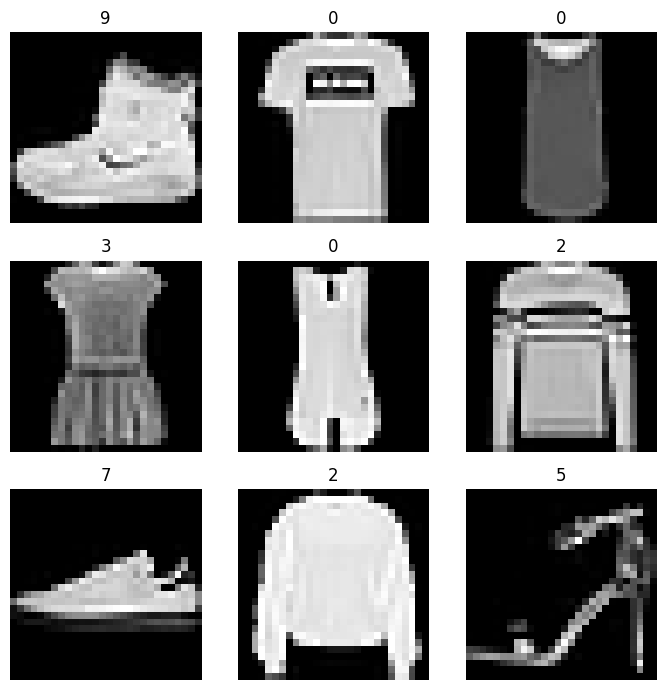

In [2]:
# visualize a few training images
plt.figure(figsize=(7, 7))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.title(str(y_train[i]))
    plt.axis("off")
plt.tight_layout()
plt.show()

### basic neural network (MLPClassifier)

In [3]:
# reshape images for scikit-learn (flatten)
X_train_flat = x_train.reshape(len(x_train), 28 * 28)
X_test_flat = x_test.reshape(len(x_test), 28 * 28)

print("Flattened shape:", X_train_flat.shape)

Flattened shape: (60000, 784)


In [10]:
# train MLPClassifier
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),   # deeper network
    activation='relu',
    solver='adam',
    alpha=1e-4,                      # L2 regularization
    learning_rate_init=0.001,
    max_iter=200,                    # train longer (very important)
    random_state=0
)

mlp.fit(X_train_flat, y_train)

y_pred_basic = mlp.predict(X_test_flat)
test_acc_basic = accuracy_score(y_test, y_pred_basic)

print("MLPClassifier test accuracy:", test_acc_basic)

MLPClassifier test accuracy: 0.8904


Confusion matrix (MLPClassifier):
[[812   3  19  20   4   2 129   0  11   0]
 [  2 982   0  11   1   0   3   0   1   0]
 [ 17   0 828  14  70   0  70   0   1   0]
 [ 13   5  13 892  36   0  39   0   2   0]
 [  1   1 110  27 800   0  57   0   3   1]
 [  0   0   0   1   0 953   0  28   1  17]
 [ 78   1  87  31  66   0 733   0   4   0]
 [  0   0   0   0   0   6   0 976   0  18]
 [  3   0   2   4   3   2   8   4 973   1]
 [  0   0   0   0   0   7   1  37   0 955]]


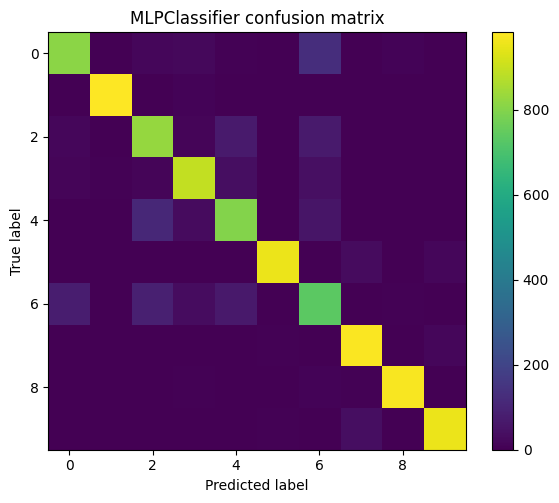

In [14]:
# confusion matrix for MLPClassifier
cm_basic = confusion_matrix(y_test, y_pred_basic)
print("Confusion matrix (MLPClassifier):")
print(cm_basic)

plt.figure(figsize=(6, 5))
plt.imshow(cm_basic, interpolation='nearest')
plt.title("MLPClassifier confusion matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.tight_layout()
plt.show()

### cnn (LeNet-5 with PyTorch)



In [19]:
# convert numpy arrays to PyTorch tensors with channel dimension (N, 1, 28, 28)
X_train_torch = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
X_test_torch = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)

y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_train_torch, y_train_torch)
test_ds = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

print("Torch train shape:", X_train_torch.shape)

Torch train shape: torch.Size([60000, 1, 28, 28])


In [20]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)          # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)                # dropout after first FC
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [23]:
model_cnn = LeNet5(num_classes=10)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

n_epochs = 15
losses_cnn = []

for epoch in range(n_epochs):
    model_cnn.train()
    running_loss = 0.0

    for Xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model_cnn(Xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    losses_cnn.append(avg_loss)
    print(f"epoch {epoch}, loss {avg_loss:.4f}")

epoch 0, loss 0.5796
epoch 1, loss 0.3563
epoch 2, loss 0.3027
epoch 3, loss 0.2648
epoch 4, loss 0.2467
epoch 5, loss 0.2273
epoch 6, loss 0.2087
epoch 7, loss 0.1947
epoch 8, loss 0.1861
epoch 9, loss 0.1741
epoch 10, loss 0.1636
epoch 11, loss 0.1525
epoch 12, loss 0.1441
epoch 13, loss 0.1390
epoch 14, loss 0.1315


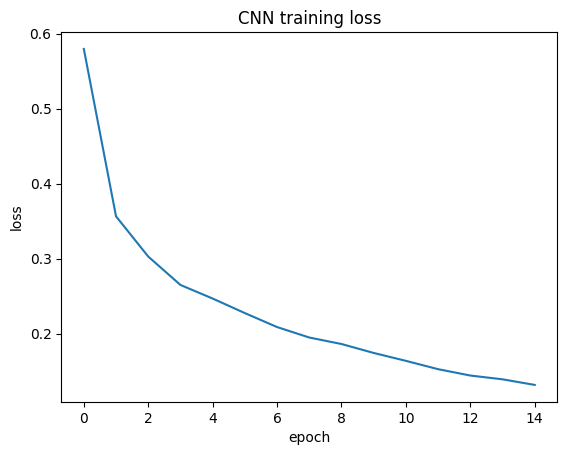

In [24]:
# plot CNN training loss
plt.figure()
plt.plot(np.arange(len(losses_cnn)), losses_cnn)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("CNN training loss")
plt.show()

In [25]:
# evaluate CNN on test set
model_cnn.eval()
correct = 0
total = 0
all_preds = []

with torch.no_grad():
    for Xb, yb in test_loader:
        outputs = model_cnn(Xb)
        _, predicted = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (predicted == yb).sum().item()
        all_preds.append(predicted.numpy())

test_acc_cnn = correct / total
all_preds = np.concatenate(all_preds)
print("CNN test accuracy:", test_acc_cnn)

CNN test accuracy: 0.9201


Confusion matrix (CNN):
[[844   0  15  15   0   3 114   0   9   0]
 [  2 981   0   9   3   0   3   0   2   0]
 [ 14   1 911   6  25   0  41   0   2   0]
 [ 17   0  13 923  17   0  28   0   2   0]
 [  1   0  74  23 850   0  52   0   0   0]
 [  0   0   0   0   0 986   0  13   0   1]
 [ 80   0  59  21  49   0 777   0  14   0]
 [  0   0   0   0   0   7   0 980   0  13]
 [  1   1   1   1   2   3   2   3 986   0]
 [  1   0   0   0   0   5   0  31   0 963]]


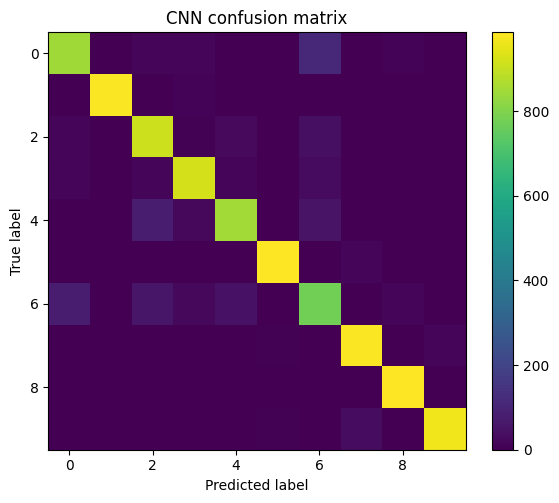

In [26]:
# confusion matrix for CNN
cm_cnn = confusion_matrix(y_test, all_preds)
print("Confusion matrix (CNN):")
print(cm_cnn)

plt.figure(figsize=(6, 5))
plt.imshow(cm_cnn, interpolation='nearest')
plt.title("CNN confusion matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.tight_layout()
plt.show()

Difference matrix (CNN - MLP):
[[ 32  -3  -4  -5  -4   1 -15   0  -2   0]
 [  0  -1   0  -2   2   0   0   0   1   0]
 [ -3   1  83  -8 -45   0 -29   0   1   0]
 [  4  -5   0  31 -19   0 -11   0   0   0]
 [  0  -1 -36  -4  50   0  -5   0  -3  -1]
 [  0   0   0  -1   0  33   0 -15  -1 -16]
 [  2  -1 -28 -10 -17   0  44   0  10   0]
 [  0   0   0   0   0   1   0   4   0  -5]
 [ -2   1  -1  -3  -1   1  -6  -1  13  -1]
 [  1   0   0   0   0  -2  -1  -6   0   8]]


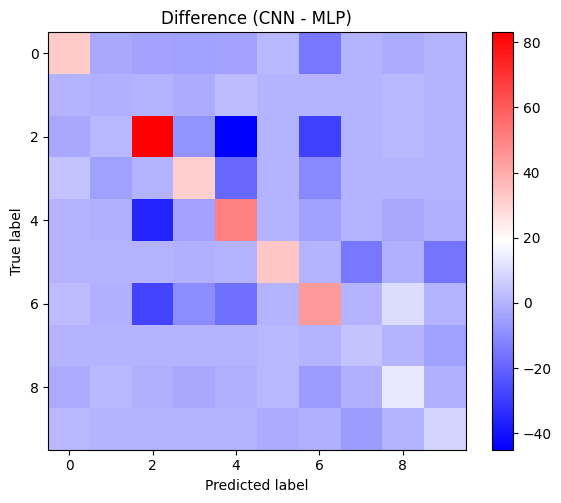

In [28]:
# Compare CNN and MLP (Difference Matrix)
diff = cm_cnn - cm_basic

print("Difference matrix (CNN - MLP):")
print(diff)

plt.figure(figsize=(6, 5))
plt.imshow(diff, cmap="bwr")
plt.title("Difference (CNN - MLP)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.tight_layout()
plt.show()

### results



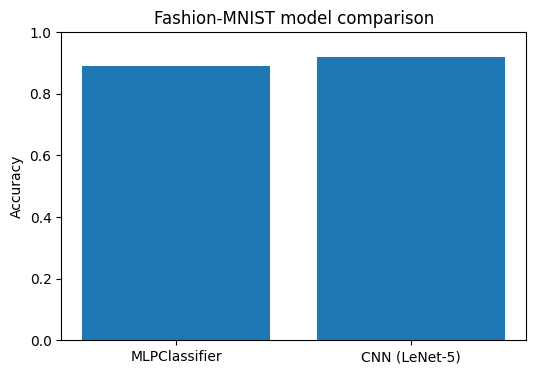

MLPClassifier accuracy: 0.8904
CNN accuracy: 0.9201


In [29]:
models = ['MLPClassifier', 'CNN (LeNet-5)']
accuracies = [test_acc_basic, test_acc_cnn]

plt.figure(figsize=(6, 4))
plt.bar(models, accuracies)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Fashion-MNIST model comparison")
plt.show()

print("MLPClassifier accuracy:", test_acc_basic)
print("CNN accuracy:", test_acc_cnn)